In [1]:
pip install Augmentor

In [2]:
from google.colab import drive
import os
import random
import shutil
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import glob
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
import imgaug.augmenters as iaa
import Augmentor

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#Data Augmentation Functions

In [4]:

def augment_images(images):
    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Affine(rotate=(-10, 10)),  # random rotations
        iaa.GaussianBlur(sigma=(0, 1.0)),  # blur images with a sigma of 0 to 1.0
        iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # add Gaussian noise
        iaa.Multiply((0.8, 1.2), per_channel=0.2),  # multiply brightness
        iaa.ContrastNormalization((0.8, 1.2))  # contrast normalization
    ], random_order=True)  # apply augmenters in random order

    # Augment images
    augmented_images = seq(images=images)
    return augmented_images

# Function to read and augment images from a folder
def read_and_augment_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            images.append(img_array)
    augmented_images = augment_images(images)
    return augmented_images



#Function that deletes all non-jpg images

In [5]:
def delete_non_jpeg_images(directory):
    deleted_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                if img.format != 'JPEG':
                    os.remove(filepath)  # Delete the file
                    print(f"Deleted: {filename}")
                    deleted_files.append(filename)
        except:
            os.remove(filepath)  # Delete the file if unable to determine format
            #print(f"{filename}: Unable to determine format. Deleted.")
            deleted_files.append(filename)
    return deleted_files

#Uploading and labeling data from Google Drive

In [6]:
data_folder_path = "/content/drive/My Drive/DS340/DS340_Project/Data"

# List of car types
car_types = ['SUV', 'Sedan', 'Pickup_Truck', 'Hatchback', 'Sports_Car']

for car_type in car_types:
    # Define the path to the current car type folder
    car_type_folder_path = os.path.join(data_folder_path, car_type)

    # Check if the car type folder exists
    if os.path.exists(car_type_folder_path):
        # Define the target directory for the current car type
        target_directory = os.path.join("/content", car_type)

        # Create the target directory if it doesn't exist
        if not os.path.exists(target_directory):
            os.makedirs(target_directory)

        # Get the list of non-JPEG files
        non_jpeg_files = delete_non_jpeg_images(car_type_folder_path)

        # Delete non-JPEG files
        for filename in non_jpeg_files:
            filepath = os.path.join(car_type_folder_path, filename)
            os.remove(filepath)

        # List all files in the current car type folder after deletion
        files_after_deletion = os.listdir(car_type_folder_path)

        # Rename and copy files with the car type prefix
        for i, file_name in enumerate(files_after_deletion):
            # Construct the new file name with the car type prefix and index
            new_file_name = f"{car_type}_{i+1}.jpg"

            # Define the current file path and the new file path
            current_file_path = os.path.join(car_type_folder_path, file_name)
            new_file_path = os.path.join(target_directory, new_file_name)

            # Copy the file
            shutil.copy(current_file_path, new_file_path)

In [7]:
!ls

drive  Hatchback  Pickup_Truck	sample_data  Sedan  Sports_Car	SUV


**Total Number of Files**


SUV: 1,493

Sports_Car: 726

Hatchback: 729

Pickup_Trunk: 1,669

Sedan: 1,222


#Train, validation test directories with cartypes as subdirectories.

In [8]:
# Function to move files from one directory to another
def move_files(source_dir, files, destination_dir):
    for file_name in files:
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(destination_dir, file_name)
        shutil.move(source_path, destination_path)

# List of directories
directories = ['Hatchback', 'Pickup_Truck', 'Sedan', 'Sports_Car', 'SUV']

# Name of the new directories
train_directory = 'train'
validation_directory = 'validation'
test_directory = 'test'

# Create the new directories if they don't exist
for directory in [train_directory, validation_directory, test_directory]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# Loop through each directory
for directory in directories:
    # Create subdirectories in train, validation, and test directories
    train_subdir = os.path.join(train_directory, directory)
    validation_subdir = os.path.join(validation_directory, directory)
    test_subdir = os.path.join(test_directory, directory)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(validation_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

    # List all files in the current directory
    files = os.listdir(directory)
    random.shuffle(files)  # Shuffle the files randomly

    # Calculate the number of files for train, validation, and test (200 for validation and 200 for test)
    num_validation_files = 200
    num_test_files = 200
    num_train_files = len(files) - num_validation_files - num_test_files

    # Split the files into train, validation, and test
    train_files = files[:num_train_files]
    validation_files = files[num_train_files:num_train_files + num_validation_files]
    test_files = files[num_train_files + num_validation_files:]

    # Move files to the train subdirectory
    move_files(directory, train_files, train_subdir)

    # Move files to the validation subdirectory
    move_files(directory, validation_files, validation_subdir)

    # Move files to the test subdirectory
    move_files(directory, test_files, test_subdir)

print("Files moved successfully!")

Files moved successfully!


In [9]:
!ls validation/SUV

SUV_1001.jpg  SUV_1217.jpg  SUV_1430.jpg  SUV_234.jpg  SUV_523.jpg  SUV_668.jpg  SUV_866.jpg
SUV_100.jpg   SUV_1220.jpg  SUV_1432.jpg  SUV_235.jpg  SUV_524.jpg  SUV_671.jpg  SUV_870.jpg
SUV_1014.jpg  SUV_1221.jpg  SUV_1434.jpg  SUV_245.jpg  SUV_534.jpg  SUV_674.jpg  SUV_872.jpg
SUV_1015.jpg  SUV_1236.jpg  SUV_1441.jpg  SUV_248.jpg  SUV_543.jpg  SUV_687.jpg  SUV_877.jpg
SUV_1016.jpg  SUV_1243.jpg  SUV_144.jpg   SUV_281.jpg  SUV_544.jpg  SUV_68.jpg	 SUV_888.jpg
SUV_1019.jpg  SUV_1253.jpg  SUV_1451.jpg  SUV_2.jpg    SUV_564.jpg  SUV_701.jpg  SUV_890.jpg
SUV_1042.jpg  SUV_1254.jpg  SUV_1453.jpg  SUV_300.jpg  SUV_565.jpg  SUV_703.jpg  SUV_8.jpg
SUV_1050.jpg  SUV_1266.jpg  SUV_1458.jpg  SUV_302.jpg  SUV_569.jpg  SUV_70.jpg	 SUV_917.jpg
SUV_1053.jpg  SUV_127.jpg   SUV_1468.jpg  SUV_313.jpg  SUV_575.jpg  SUV_710.jpg  SUV_921.jpg
SUV_1059.jpg  SUV_1286.jpg  SUV_1472.jpg  SUV_31.jpg   SUV_576.jpg  SUV_718.jpg  SUV_924.jpg
SUV_1066.jpg  SUV_1287.jpg  SUV_1474.jpg  SUV_322.jpg  SUV_578.jpg  SUV_73

# Data Augmentation



In [10]:
# Data Augmentation for every car

# Hatchback
train_directory = "/content/train/Hatchback"

# Create an Augmentor pipeline
p = Augmentor.Pipeline(train_directory)

# Adding augmentation operations
# Flip horizontally with a probability of 0.5
p.flip_left_right(probability=0.5)
# Example: Rotate by a random angle between -10 and 10 degrees
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
# Add more augmentation operations as needed

# Set the number of augmented images you want to generate
p.sample(971)

output_dir = "/content/train/Hatchback/output"
suv_dir = "/content/train/Hatchback"

# Move all files from output to Hatchback
for filename in os.listdir(output_dir):
    src = os.path.join(output_dir, filename)
    dst = os.path.join(suv_dir, filename)
    shutil.move(src, dst)
os.rmdir(output_dir)


# SUV
train_directory = "/content/train/SUV"

p = Augmentor.Pipeline(train_directory)
p.flip_left_right(probability=0.5)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(207)

output_dir = "/content/train/SUV/output"
suv_dir = "/content/train/SUV"

for filename in os.listdir(output_dir):
    src = os.path.join(output_dir, filename)
    dst = os.path.join(suv_dir, filename)
    shutil.move(src, dst)
os.rmdir(output_dir)


# Pickup_Truck
train_directory = "/content/train/Pickup_Truck"

p = Augmentor.Pipeline(train_directory)
p.flip_left_right(probability=0.5)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(31)

output_dir = "/content/train/Pickup_Truck/output"
suv_dir = "/content/train/Pickup_Truck"

for filename in os.listdir(output_dir):
    src = os.path.join(output_dir, filename)
    dst = os.path.join(suv_dir, filename)
    shutil.move(src, dst)
os.rmdir(output_dir)


# Sedan
train_directory = "/content/train/Sedan"

p = Augmentor.Pipeline(train_directory)
p.flip_left_right(probability=0.5)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(478)

output_dir = "/content/train/Sedan/output"
suv_dir = "/content/train/Sedan"

# Move all files from output to SUV
for filename in os.listdir(output_dir):
    src = os.path.join(output_dir, filename)
    dst = os.path.join(suv_dir, filename)
    shutil.move(src, dst)
os.rmdir(output_dir)


# Sports_Car
train_directory = "/content/train/Sports_Car"

p = Augmentor.Pipeline(train_directory)
p.flip_left_right(probability=0.5)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(974)

output_dir = "/content/train/Sports_Car/output"
suv_dir = "/content/train/Sports_Car"

# Move all files from output to SUV
for filename in os.listdir(output_dir):
    src = os.path.join(output_dir, filename)
    dst = os.path.join(suv_dir, filename)
    shutil.move(src, dst)
os.rmdir(output_dir)

Initialised with 329 image(s) found.
Output directory set to /content/train/Hatchback/output.

Processing <PIL.Image.Image image mode=RGB size=341x240 at 0x7F83AC63D8D0>: 100%|██████████| 971/971 [00:15<00:00, 63.76 Samples/s]


Initialised with 1087 image(s) found.
Output directory set to /content/train/SUV/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=260x194 at 0x7F83ADFB3E80>: 100%|██████████| 207/207 [00:02<00:00, 87.01 Samples/s] 


Initialised with 1299 image(s) found.
Output directory set to /content/train/Pickup_Truck/output.

Processing <PIL.Image.Image image mode=RGB size=116x130 at 0x7F83AC63CE50>: 100%|██████████| 31/31 [00:00<00:00, 45.73 Samples/s]


Initialised with 822 image(s) found.
Output directory set to /content/train/Sedan/output.

Processing <PIL.Image.Image image mode=RGB size=338x202 at 0x7F83AC609BD0>: 100%|██████████| 478/478 [00:05<00:00, 93.80 Samples/s] 


Initialised with 326 image(s) found.
Output directory set to /content/train/Sports_Car/output.

Processing <PIL.Image.Image image mode=RGB size=1179x483 at 0x7F83AC6DEFE0>: 100%|██████████| 974/974 [01:20<00:00, 12.07 Samples/s]


All car types have 1300 images in training, 200 in validation, and 200 in testing

In [11]:
# Viewing the files of SUV subdirectory in train directory
# !ls train/Sports_Car

# Assigning classes to images in training, validation, and testing set

In [12]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train",
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/validation",
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/test",
    labels='inferred',
    #subset="testing",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True, # Not really sure what this does
)


Found 6524 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


#Models

##VGG16 Sequential

In [13]:
# (Model 1)

model1 = VGG16(include_top=False, input_shape=(180, 180, 3)) # we'll replace the "top" with our own layers
for layer in model1.layers:
    layer.trainable = False

# Add new classifier layers
flat = layers.Flatten()(model1.layers[-1].output) # connect to last layer of VGG
drop1 = layers.Dropout(0.5)(flat)
cls = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.5)(cls)
output = layers.Dense(5, activation='softmax')(drop2) #


# Define new model
model1 = Model(inputs=model1.inputs, outputs=output)

# Compile model
model1.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(train_ds, epochs=7,validation_data=val_ds)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/7
204/204 [==============================] - 38s 144ms/step - loss: 3.0462 - accuracy: 0.6291 - val_loss: 0.5189 - val_accuracy: 0.8510
Epoch 2/7
204/204 [==============================] - 24s 114ms/step - loss: 0.7210 - accuracy: 0.7511 - val_loss: 0.3364 - val_accuracy: 0.8940
Epoch 3/7
204/204 [==============================] - 25s 119ms/step - loss: 0.5723 - accuracy: 0.8046 - val_loss: 0.3641 - val_accuracy: 0.8910
Epoch 4/7
204/204 [==============================] - 25s 121ms/step - loss: 0.4834 - accuracy: 0.8246 - val_loss: 0.2778 - val_accuracy: 0.9280
Epoch 5/7
204/204 [==============================] - 25s 122ms/step - loss: 0.4340 - accuracy: 0.8509 - val_loss: 0.2855 - val_accuracy: 0.9440
Epoch 6/7
204/204 [==============================] - 26s 124ms/step - loss: 0.3670 - accuracy: 0.8702 - val_loss: 0.2828 - val_accuracy: 0.9350
Epoch 7/7
204/204 [==============================] - 25s 120ms/step - l

In [14]:
# Model 1 testing set accuracy and loss

loss, accuracy = model1.evaluate(test_ds)
loss = round((loss),2)
accuracy = round((accuracy * 100),2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy,"%")

32/32 [==============================] - 4s 101ms/step - loss: 0.1445 - accuracy: 0.9560
Test Loss: 0.14
Test Accuracy: 95.6 %


In [15]:
# (Model 2)

# Pulling pretrained classes from VGG16
model_vgg16 = VGG16(weights='imagenet', include_top=True)  # Include top layers for classification

# Get the class labels for ImageNet
class_labels = decode_predictions(np.zeros((1, 1000)), top=1000)
class_names = [label[1] for label in class_labels[0]]

# After looking through list of pretrained classes, we only found sports_car and pickup
# Find the indices of 'pickup' and 'sports_car' in class_names
pickup_index = class_names.index('pickup')
sports_car_index = class_names.index('sports_car')

# Create your model based on VGG16
model_base = VGG16(include_top=False, input_shape=(180, 180, 3))

# Freeze the layers of the base model
for layer in model_base.layers:
    layer.trainable = False

# Adding my model to pretrained classes of VGG
flat = layers.Flatten()(model_base.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat)
cls = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.5)(cls)

# Adjust the number of classes in the output layer
new_class_names = class_names[:pickup_index] + ['Pickup_Truck'] + class_names[pickup_index+1:sports_car_index] + ['Sports_Car'] + class_names[sports_car_index+1:]
output = layers.Dense(len(new_class_names), activation='softmax')(drop2)

# Defining model
model2 = Model(inputs=model_base.inputs, outputs=output)

# Compile the final model
model2.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now you can train your final model
model2.fit(train_ds, epochs=7, validation_data=val_ds)


35363/35363 [==============================] - 0s 0us/step
Epoch 1/7
204/204 [==============================] - 28s 127ms/step - loss: 1.7423 - accuracy: 0.6960 - val_loss: 0.2497 - val_accuracy: 0.9160
Epoch 2/7
204/204 [==============================] - 26s 124ms/step - loss: 0.5033 - accuracy: 0.8418 - val_loss: 0.1479 - val_accuracy: 0.9690
Epoch 3/7
204/204 [==============================] - 25s 119ms/step - loss: 0.4395 - accuracy: 0.8682 - val_loss: 0.1666 - val_accuracy: 0.9710
Epoch 4/7
204/204 [==============================] - 25s 120ms/step - loss: 0.3261 - accuracy: 0.8968 - val_loss: 0.1609 - val_accuracy: 0.9690
Epoch 5/7
204/204 [==============================] - 25s 123ms/step - loss: 0.3145 - accuracy: 0.9024 - val_loss: 0.1831 - val_accuracy: 0.9680
Epoch 6/7
204/204 [==============================] - 26s 123ms/step - loss: 0.2982 - accuracy: 0.9093 - val_loss: 0.1876 - val_accuracy: 0.9580
Epoch 7/7
204/204 [==============================] - 25s 121ms/step - loss: 0

In [16]:
# Model 2 testing set accuracy and loss

loss, accuracy = model2.evaluate(test_ds)
loss = round((loss),2)
accuracy = round((accuracy * 100),2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy,"%")

32/32 [==============================] - 4s 101ms/step - loss: 0.1015 - accuracy: 0.9730
Test Loss: 0.1
Test Accuracy: 97.3 %


##Sequential

In [17]:
# (Model 3)

model3 = Sequential()

# Define convolutional layers
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2)))

# Define classification layers
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

# Compiling Model
model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.fit(train_ds, epochs=7, validation_data=val_ds)


Epoch 1/7
204/204 [==============================] - 36s 133ms/step - loss: 2.9791 - accuracy: 0.2115 - val_loss: 1.6089 - val_accuracy: 0.2280
Epoch 2/7
204/204 [==============================] - 22s 106ms/step - loss: 1.6161 - accuracy: 0.2157 - val_loss: 1.6097 - val_accuracy: 0.2030
Epoch 3/7
204/204 [==============================] - 21s 100ms/step - loss: 1.6103 - accuracy: 0.2028 - val_loss: 1.6092 - val_accuracy: 0.2030
Epoch 4/7
204/204 [==============================] - 21s 102ms/step - loss: 1.4747 - accuracy: 0.3529 - val_loss: 1.1354 - val_accuracy: 0.5760
Epoch 5/7
204/204 [==============================] - 23s 108ms/step - loss: 1.0940 - accuracy: 0.5765 - val_loss: 0.7741 - val_accuracy: 0.7340
Epoch 6/7
204/204 [==============================] - 22s 106ms/step - loss: 0.8208 - accuracy: 0.6864 - val_loss: 0.6576 - val_accuracy: 0.7840
Epoch 7/7
204/204 [==============================] - 22s 108ms/step - loss: 0.6592 - accuracy: 0.7551 - val_loss: 0.4780 - val_accuracy:

In [18]:
# Model 3 testing set accuracy and loss

loss, accuracy = model3.evaluate(test_ds)
loss = round((loss),2)
accuracy = round((accuracy * 100),2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy,"%")

32/32 [==============================] - 2s 59ms/step - loss: 0.4391 - accuracy: 0.8510
Test Loss: 0.44
Test Accuracy: 85.1 %


##Keras Sequential

In [19]:
# (Model 4)

input_shape = (180, 180, 3)
model4 = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")  # Output layer with 5 neurons and softmax activation
])

# Compiling Model
model4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  # Sparse categorical cross-entropy loss
model4.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
204/204 [==============================] - 19s 80ms/step - loss: 0.8575 - accuracy: 0.6845 - val_loss: 0.5355 - val_accuracy: 0.8160
Epoch 2/15
204/204 [==============================] - 18s 88ms/step - loss: 0.2925 - accuracy: 0.9016 - val_loss: 0.4628 - val_accuracy: 0.8570
Epoch 3/15
204/204 [==============================] - 16s 76ms/step - loss: 0.1200 - accuracy: 0.9611 - val_loss: 0.4764 - val_accuracy: 0.8840
Epoch 4/15
204/204 [==============================] - 15s 74ms/step - loss: 0.0769 - accuracy: 0.9775 - val_loss: 0.5138 - val_accuracy: 0.8900
Epoch 5/15
204/204 [==============================] - 16s 75ms/step - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.6306 - val_accuracy: 0.8990
Epoch 6/15
204/204 [==============================] - 18s 83ms/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.8758 - val_accuracy: 0.8760
Epoch 7/15
204/204 [==============================] - 16s 75ms/step - loss: 0.0290 - accuracy: 0.9896 - val_loss: 0.7406 - val_accuracy:

In [20]:
# Model 4 testing set accuracy and loss

loss, accuracy = model4.evaluate(test_ds)
loss = round((loss),2)
accuracy = round((accuracy * 100),2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy,"%")

32/32 [==============================] - 2s 54ms/step - loss: 0.6424 - accuracy: 0.9150
Test Loss: 0.64
Test Accuracy: 91.5 %


In [21]:
# (Model 5)
# Same as model 3 but with a deeper architecture

input_shape = (180,180,3)

model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # More convolutional & pooling layers
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(5, activation="softmax"),
    ]
)

# Compiling Model
model5.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model5.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
204/204 [==============================] - 22s 90ms/step - loss: 1.1809 - accuracy: 0.5110 - val_loss: 0.8899 - val_accuracy: 0.6730
Epoch 2/15
204/204 [==============================] - 18s 85ms/step - loss: 0.6996 - accuracy: 0.7405 - val_loss: 0.6738 - val_accuracy: 0.7700
Epoch 3/15
204/204 [==============================] - 18s 83ms/step - loss: 0.4368 - accuracy: 0.8437 - val_loss: 0.4112 - val_accuracy: 0.8530
Epoch 4/15
204/204 [==============================] - 16s 78ms/step - loss: 0.3117 - accuracy: 0.8935 - val_loss: 0.3845 - val_accuracy: 0.8850
Epoch 5/15
204/204 [==============================] - 19s 90ms/step - loss: 0.2010 - accuracy: 0.9303 - val_loss: 0.3448 - val_accuracy: 0.9120
Epoch 6/15
204/204 [==============================] - 16s 78ms/step - loss: 0.1611 - accuracy: 0.9421 - val_loss: 0.4085 - val_accuracy: 0.9200
Epoch 7/15
204/204 [==============================] - 17s 82ms/step - loss: 0.1074 - accuracy: 0.9634 - val_loss: 0.3199 - val_accuracy:

In [22]:
# Model 5 testing set accuracy and loss

loss, accuracy = model5.evaluate(test_ds)
loss = round((loss),2)
accuracy = round((accuracy * 100),2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy,"%")

32/32 [==============================] - 2s 57ms/step - loss: 0.3639 - accuracy: 0.9420
Test Loss: 0.36
Test Accuracy: 94.2 %


#Passing through external image to test model
##Using model with highest accuracy and lowest loss (Model 2)
##Images are not in any set (train, validation, test)

1/1 [==============================] - 0s 18ms/step
Predicted Class: Sports_Car
Confidence Score: 0.06531709


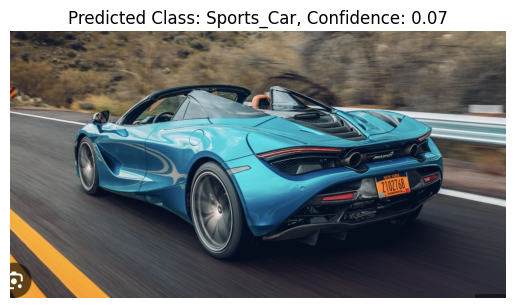

1/1 [==============================] - 0s 18ms/step
Predicted Class: Hatchback
Confidence Score: 0.0065266374


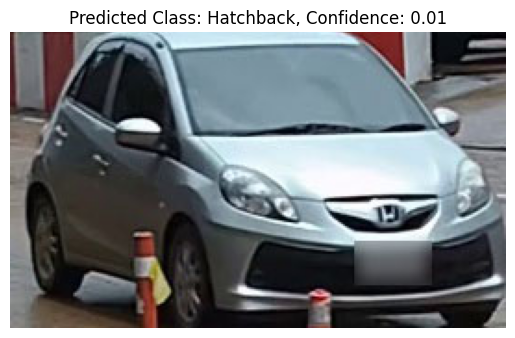

1/1 [==============================] - 0s 18ms/step
Predicted Class: Pickup_Truck
Confidence Score: 0.004390645


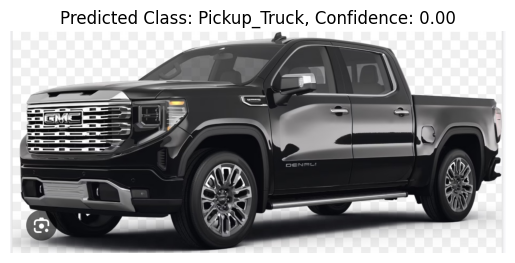

In [28]:
# Function to preprocess the image
def preprocess_image(image_path, target_size):
    # Open the image
    img = Image.open(image_path)
    # Resize the image to match the input size of your model
    img = img.resize(target_size)
    # Convert the image to a numpy array and normalize the pixel values
    img_array = np.array(img) / 255.0
    # Add batch dimension as your model expects batches of images
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the class of the image
def predict_image(model, image_path, target_size, class_names):
    # Preprocess the image
    img = preprocess_image(image_path, target_size)
    # Make predictions using the model
    predictions = model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    # Get the class label
    predicted_class = class_names[predicted_class_index]
    # Get the confidence score
    confidence_score = predictions[0][predicted_class_index]
    return predicted_class, confidence_score

# Path to the uploaded image
uploaded_image_path = "McLaren_Sports.jpg"

# Using model 2

# Define the target size (same as the input size of your model)
target_size = (180, 180)

# Define the class names
class_names = ['SUV', 'Sedan', 'Pickup_Truck', 'Hatchback', 'Sports_Car']

# Predict the class of the uploaded image
predicted_class, confidence_score = predict_image(model2, uploaded_image_path, target_size, class_names)


# Print the predicted class and confidence score
print("Predicted Class:", predicted_class)
print("Confidence Score:", confidence_score)

# Optionally, you can visualize the uploaded image
img = Image.open(uploaded_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class}, Confidence: {confidence_score:.2f}")
plt.show()


# Second Test
uploaded_image_path2 = "Hatchback_17.jpg"

# Predict the class of the uploaded image
predicted_class2, confidence_score2 = predict_image(model2, uploaded_image_path2, target_size, class_names)


# Print the predicted class and confidence score
print("Predicted Class:", predicted_class2)
print("Confidence Score:", confidence_score2)

# Optionally, you can visualize the uploaded image
img = Image.open(uploaded_image_path2)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class2}, Confidence: {confidence_score2:.2f}")
plt.show()


# Third Test
uploaded_image_path2 = "GMC_Pickup.jpg"

# Predict the class of the uploaded image
predicted_class2, confidence_score2 = predict_image(model2, uploaded_image_path2, target_size, class_names)


# Print the predicted class and confidence score
print("Predicted Class:", predicted_class2)
print("Confidence Score:", confidence_score2)

# Optionally, you can visualize the uploaded image
img = Image.open(uploaded_image_path2)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class2}, Confidence: {confidence_score2:.2f}")
plt.show()